In [1]:
# --- Secure API Key Setup ---
import os
import getpass

# Required: OpenAI API Key
os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter your OpenAI API key: ")

# Optional: Enable LangChain tracing via LangSmith (for debugging / observability)
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_API_KEY"] = getpass.getpass("Enter your LangSmith API key (or press Enter to skip): ")

# Optional: Tavily key (useful if you decide to do web search augmentation later)
os.environ["TAVILY_API_KEY"] = getpass.getpass("Enter your Tavily API key (or press Enter to skip): ")

Enter your OpenAI API key:  ········
Enter your LangSmith API key (or press Enter to skip):  ········
Enter your Tavily API key (or press Enter to skip):  ········


In [3]:
from langchain_openai import ChatOpenAI

# Initialize the chat model for response generation
llm = ChatOpenAI(model="gpt-4o-mini")

In [5]:
from langchain_openai import OpenAIEmbeddings

# Initialize the OpenAI embeddings model
# This will be used to embed your document chunks and user queries
embeddings = OpenAIEmbeddings()

In [7]:
from langchain_core.vectorstores import InMemoryVectorStore

# Initialize an in-memory vector store using the OpenAI embeddings model
# This store will hold your embedded document chunks for retrieval
vector_store = InMemoryVectorStore(embeddings)

In [13]:
%%capture --no-stderr
%pip install --upgrade --quiet langgraph langchain-community beautifulsoup4

In [17]:
import bs4  # Used to filter and parse HTML
from langchain import hub  # For pulling prebuilt prompts later
from langchain_community.document_loaders import WebBaseLoader  # Loads website content
from langchain_core.documents import Document  # LangChain document format
from langchain_text_splitters import RecursiveCharacterTextSplitter  # Breaks text into chunks
from typing_extensions import List, TypedDict  # For later use in state typing

# --- Load the blog post from Lilian Weng’s site ---
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),  # URL to load
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(  # Filter out only these HTML elements
            class_=("post-content", "post-title", "post-header")
        )
    ),
)
docs = loader.load()  # Load the web page into a list of Document objects

# --- Split the document into manageable chunks ---
# Chunks will be used for embedding and vector search
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,        # Max characters per chunk
    chunk_overlap=200       # Overlap between chunks to preserve context
)
all_splits = text_splitter.split_documents(docs)  # Final list of chunks

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [19]:
# --- Add the split blog post chunks to your vector store ---
# This indexes them so they can be retrieved during similarity search
_ = vector_store.add_documents(documents=all_splits)

In [21]:
from langgraph.graph import MessagesState, StateGraph

# --- Initialize a LangGraph builder using MessagesState ---
# This state automatically handles a sequence of messages
# including user input, LLM responses, tool calls, and tool outputs
graph_builder = StateGraph(MessagesState)

In [23]:
from langchain_core.tools import tool

# --- Define a retrieval tool that the LLM can call during a conversation ---
@tool(response_format="content_and_artifact")  # Return both readable text and structured data
def retrieve(query: str):
    """Retrieve information related to a query."""
    
    # Perform semantic search over the indexed document chunks
    retrieved_docs = vector_store.similarity_search(query, k=2)
    
    # Create a readable summary of results for the model to work with
    serialized = "\n\n".join(
        f"Source: {doc.metadata}\nContent: {doc.page_content}"
        for doc in retrieved_docs
    )
    
    # Return both the summary and the actual documents
    return serialized, retrieved_docs

In [25]:
from langchain_core.messages import SystemMessage  # Used to create system-level prompts
from langgraph.prebuilt import ToolNode  # Handles tool execution and state tracking

# --- Step 1: Generate a response or tool call using the LLM ---
def query_or_respond(state: MessagesState):
    """Generate a tool call for retrieval OR directly respond to the user."""
    
    # Bind the retrieval tool so the LLM can choose to call it
    llm_with_tools = llm.bind_tools([retrieve])
    
    # Invoke the LLM on the message history — may return an answer OR a tool call
    response = llm_with_tools.invoke(state["messages"])
    
    # Return the new AIMessage and append it to the state
    return {"messages": [response]}


# --- Step 2: Execute the retrieval tool, if it was called ---
# ToolNode automatically runs the tool and adds its output to the message state as a ToolMessage
tools = ToolNode([retrieve])


# --- Step 3: Generate a final answer using the retrieved content ---
def generate(state: MessagesState):
    """Generate the final answer using context from ToolMessages."""
    
    # Extract only the most recent ToolMessages (retrieved docs)
    recent_tool_messages = []
    for message in reversed(state["messages"]):
        if message.type == "tool":
            recent_tool_messages.append(message)
        else:
            break
    tool_messages = recent_tool_messages[::-1]  # Keep in original order

    # Format ToolMessages into readable context for the LLM
    docs_content = "\n\n".join(doc.content for doc in tool_messages)
    
    # Create a system prompt guiding the model to answer concisely using the retrieved context
    system_message_content = (
        "You are an assistant for question-answering tasks. "
        "Use the following pieces of retrieved context to answer the question. "
        "If you don't know the answer, say that you don't know. "
        "Use three sentences maximum and keep the answer concise.\n\n"
        f"{docs_content}"
    )
    
    # Keep relevant message history (human, system, and AI without tool calls)
    conversation_messages = [
        message
        for message in state["messages"]
        if message.type in ("human", "system")
        or (message.type == "ai" and not message.tool_calls)
    ]
    
    # Create the prompt for the LLM using system + user messages
    prompt = [SystemMessage(system_message_content)] + conversation_messages

    # Generate the final answer from the model
    response = llm.invoke(prompt)
    
    # Return the message to append to chat history
    return {"messages": [response]}

In [27]:
from langgraph.graph import END
from langgraph.prebuilt import ToolNode, tools_condition

# --- Add nodes to the graph ---
# Each node corresponds to a stage in the RAG pipeline
graph_builder.add_node(query_or_respond)  # Step 1: Model generates tool call or direct response
graph_builder.add_node(tools)             # Step 2: If tool was called, run it (retrieval)
graph_builder.add_node(generate)          # Step 3: Final answer generation using retrieved context

# --- Define the starting point of the graph ---
graph_builder.set_entry_point("query_or_respond")

# --- Conditional logic for tool execution ---
# If the model calls a tool, go to "tools"
# If not, the chain ends directly with the initial response
graph_builder.add_conditional_edges(
    "query_or_respond",
    tools_condition,  # This built-in condition checks for tool calls in the AIMessage
    {
        END: END,      # No tool call? End the graph here.
        "tools": "tools",  # Tool call detected? Run the tool.
    },
)

# --- Final transition: after retrieval, generate the final answer, then end the graph ---
graph_builder.add_edge("tools", "generate")
graph_builder.add_edge("generate", END)

# --- Compile the graph into a callable app ---
graph = graph_builder.compile()

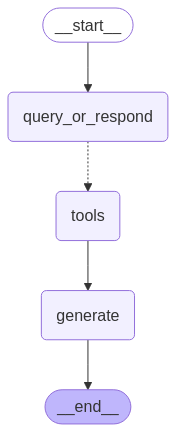

In [41]:
from IPython.display import Image, display

# Render and display a visual diagram of your LangGraph structure
# This is helpful to understand the flow between nodes and how conditions route the graph
display(Image(graph.get_graph().draw_mermaid_png()))

In [43]:
# Define the user's input message
input_message = "What is Task Decomposition?"

# Stream the conversation step-by-step through the LangGraph
# This will show each step in the workflow (tool call, retrieval, final answer, etc.)
for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},  # Initial input wrapped as message
    stream_mode="values",  # Only the message values (no metadata)
):
    # Display the final message from each step (pretty-printed for readability)
    step["messages"][-1].pretty_print()

================================ Human Message =================================

What is Task Decomposition?
================================== Ai Message ==================================
Tool Calls:
  retrieve (call_SzwI2vVImS6P7OUjomlLl4Um)
 Call ID: call_SzwI2vVImS6P7OUjomlLl4Um
  Args:
    query: Task Decomposition
================================= Tool Message =================================
Name: retrieve

Source: {'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}
Content: Fig. 1. Overview of a LLM-powered autonomous agent system.
Component One: Planning#
A complicated task usually involves many steps. An agent needs to know what they are and plan ahead.
Task Decomposition#
Chain of thought (CoT; Wei et al. 2022) has become a standard prompting technique for enhancing model performance on complex tasks. The model is instructed to “think step by step” to utilize more test-time computation to decompose hard tasks into smaller and simpler steps. CoT transforms b

In [45]:
from langgraph.checkpoint.memory import MemorySaver  # In-memory storage for chat state

# Create a memory checkpointer (in-memory version)
memory = MemorySaver()

# Recompile the graph with memory support enabled
graph = graph_builder.compile(checkpointer=memory)

# Assign a unique thread ID for the conversation (helps track history)
config = {"configurable": {"thread_id": "abc123"}}

In [47]:
# User input (first message in the conversation)
input_message = "What is Task Decomposition?"

# Stream the graph step-by-step, now with memory enabled
for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},  # Initial message
    stream_mode="values",  # Only return message values (not full metadata)
    config=config,  # Include conversation thread ID for memory
):
    # Print the final message at each step
    step["messages"][-1].pretty_print()

================================ Human Message =================================

What is Task Decomposition?
================================== Ai Message ==================================
Tool Calls:
  retrieve (call_87IAkl9fpRN98kKr0dmfgKXo)
 Call ID: call_87IAkl9fpRN98kKr0dmfgKXo
  Args:
    query: Task Decomposition
================================= Tool Message =================================
Name: retrieve

Source: {'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}
Content: Fig. 1. Overview of a LLM-powered autonomous agent system.
Component One: Planning#
A complicated task usually involves many steps. An agent needs to know what they are and plan ahead.
Task Decomposition#
Chain of thought (CoT; Wei et al. 2022) has become a standard prompting technique for enhancing model performance on complex tasks. The model is instructed to “think step by step” to utilize more test-time computation to decompose hard tasks into smaller and simpler steps. CoT transforms b

In [49]:
# Follow-up question, relying on memory from previous conversation turns
input_message = "Can you look up some common ways of doing it?"

# Stream the response from the graph, using the same thread_id
for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},  # Follow-up message
    stream_mode="values",  # Return message content only
    config=config,  # Use the same conversation ID for memory
):
    # Show the final message generated at this step
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Can you look up some common ways of doing it?
================================== Ai Message ==================================
Tool Calls:
  retrieve (call_B7wlc2GruujXT0ovp4ZvbRR3)
 Call ID: call_B7wlc2GruujXT0ovp4ZvbRR3
  Args:
    query: common methods of task decomposition
================================= Tool Message =================================
Name: retrieve

Source: {'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}
Content: Tree of Thoughts (Yao et al. 2023) extends CoT by exploring multiple reasoning possibilities at each step. It first decomposes the problem into multiple thought steps and generates multiple thoughts per step, creating a tree structure. The search process can be BFS (breadth-first search) or DFS (depth-first search) with each state evaluated by a classifier (via a prompt) or majority vote.
Task decomposition can be done (1) by LLM with simple prompting lik

In [51]:
from langgraph.prebuilt import create_react_agent

# Create a ReAct-style agent executor using your LLM and tools
# This agent can call `retrieve` multiple times if needed
# It uses the same memory so conversation history is preserved
agent_executor = create_react_agent(llm, [retrieve], checkpointer=memory)

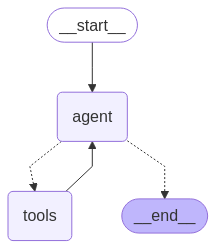

In [53]:
from IPython.display import Image, display

# Visualize the structure of the agent's execution graph
# This helps you understand how the agent decides between thinking, tool use, and final response
display(Image(agent_executor.get_graph().draw_mermaid_png()))


In [55]:
# Define a new thread ID to track this conversation separately
config = {"configurable": {"thread_id": "def234"}}

# Multi-step user question that encourages iteration
input_message = (
    "What is the standard method for Task Decomposition?\n\n"
    "Once you get the answer, look up common extensions of that method."
)

# Stream each step of the agent's reasoning and actions
for event in agent_executor.stream(
    {"messages": [{"role": "user", "content": input_message}]},  # Input message
    stream_mode="values",  # Show messages only
    config=config,  # Maintain history with unique thread ID
):
    # Print the last message at each stage of the agent's execution
    event["messages"][-1].pretty_print()

================================ Human Message =================================

What is the standard method for Task Decomposition?

Once you get the answer, look up common extensions of that method.
================================== Ai Message ==================================
Tool Calls:
  retrieve (call_ESiNv4Px6UnNxaYjV51Zxe6M)
 Call ID: call_ESiNv4Px6UnNxaYjV51Zxe6M
  Args:
    query: standard method for Task Decomposition
================================= Tool Message =================================
Name: retrieve

Source: {'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}
Content: Tree of Thoughts (Yao et al. 2023) extends CoT by exploring multiple reasoning possibilities at each step. It first decomposes the problem into multiple thought steps and generates multiple thoughts per step, creating a tree structure. The search process can be BFS (breadth-first search) or DFS (depth-first search) with each state evaluated by a classifier (via a prompt) or majori

In [57]:
# Define a new thread ID to track this conversation separately
config = {"configurable": {"thread_id": "def234"}}

# Multi-step user question that encourages iteration
input_message = (
    "What is the standard method for Task Decomposition?\n\n"
    "Once you get the answer, look up common extensions of that method."
)

# Stream each step of the agent's reasoning and actions
for event in agent_executor.stream(
    {"messages": [{"role": "user", "content": input_message}]},  # Input message
    stream_mode="values",  # Show messages only
    config=config,  # Maintain history with unique thread ID
):
    # Print the last message at each stage of the agent's execution
    event["messages"][-1].pretty_print()

================================ Human Message =================================

What is the standard method for Task Decomposition?

Once you get the answer, look up common extensions of that method.
================================== Ai Message ==================================
Tool Calls:
  retrieve (call_h7srln4UCjQPxRrbw3e67Xuw)
 Call ID: call_h7srln4UCjQPxRrbw3e67Xuw
  Args:
    query: standard method for Task Decomposition
================================= Tool Message =================================
Name: retrieve

Source: {'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}
Content: Tree of Thoughts (Yao et al. 2023) extends CoT by exploring multiple reasoning possibilities at each step. It first decomposes the problem into multiple thought steps and generates multiple thoughts per step, creating a tree structure. The search process can be BFS (breadth-first search) or DFS (depth-first search) with each state evaluated by a classifier (via a prompt) or majori